# 01: Data Exploration

Distributions, keyword frequencies, correlations, missing data


## **Setup**

### Imports

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from data.load import load_and_verify_graph

### Plotting Prep

In [2]:
color_top = "slateblue"
color_recent = "lightcoral"
colors = [color_top, color_recent]

def add_grid(ax, axis="x"):
    ax.set_axisbelow(True)
    ax.grid(axis=axis,  alpha=0.5)

## **Load Data**

### Load and Verify

In [3]:
GRAPH_DATA_DIR = Path("../data/graph")
GRAPH_NAME = "graph_top_n200_20250717"
G_top, df_edges_top = load_and_verify_graph(GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_top_n200_20250717':
  572 nodes
  200 core packages
  1,245 dependencies
  directed=True

Sample node metadata:
  opentelemetry-sdk: SourceRank=21, stars=2068, forks=717
  grpcio: SourceRank=25, stars=43324, forks=10849
  click: SourceRank=28, stars=16397, forks=1438
  psutil: SourceRank=27, stars=10733, forks=1415
  google-auth: SourceRank=21, stars=828, forks=322

Sample edge metadata:
  opentelemetry-sdk -> opentelemetry-api: kind=runtime, optional=False
  opentelemetry-sdk -> opentelemetry-semantic-conventions: kind=runtime, optional=False
  opentelemetry-sdk -> typing-extensions: kind=runtime, optional=False
  grpcio -> grpcio-tools: kind=protobuf, optional=True
  click -> colorama: kind=runtime, optional=False


In [4]:
RECENT_GRAPH_NAME = "graph_recent_n200_20250717"
G_recent, df_edges_recent = load_and_verify_graph(RECENT_GRAPH_NAME, GRAPH_DATA_DIR)

Graph 'graph_recent_n200_20250717':
  975 nodes
  200 core packages
  2,070 dependencies
  directed=True

Sample node metadata:
  baseballquery: SourceRank=8, stars=3, forks=0
  business-rules-enhanced: SourceRank=10, stars=11, forks=5
  invenio-records-permissions: SourceRank=12, stars=0, forks=28
  gamesentenceminer: SourceRank=9, stars=78, forks=3
  pbipandas: SourceRank=3, stars=0, forks=0

Sample edge metadata:
  baseballquery -> numpy: kind=runtime, optional=False
  baseballquery -> pandas: kind=runtime, optional=False
  baseballquery -> pyarrow: kind=runtime, optional=False
  baseballquery -> requests: kind=runtime, optional=False
  baseballquery -> sqlalchemy: kind=runtime, optional=False


### Missing Metadata

In [5]:
def show_nodes_with_missing_metadata(G, max_display=20):
    missing_metadata_nodes = [node for node, data in G.nodes(data=True) if data.get('missing_metadata')]

    if missing_metadata_nodes:
        print(f"Nodes with missing metadata: {len(missing_metadata_nodes):,}")
        print("-" * 40)
        for i, node in enumerate(missing_metadata_nodes[:max_display], 1):
            print(f"{i:3d}. {node}")
        if len(missing_metadata_nodes) > max_display:
            print(f"... and {len(missing_metadata_nodes) - max_display} more.")
        print("-" * 40)
    else:
        print("All nodes have complete metadata.")

print("Top packages graph:")
show_nodes_with_missing_metadata(G_top)
print()
print("Recent packages graph:")
show_nodes_with_missing_metadata(G_recent)

Top packages graph:
Nodes with missing metadata: 15
----------------------------------------
  1. pathspec
  2. importlib-metadata
  3. ptyprocess
  4. pandas
  5. gitpython
  6. jsonschema
  7. vulture
  8. deprecation
  9. jupyterlite-pyodide-kernel
 10. scikit-umfpack
 11. pendulum
 12. psycopg2
 13. sqlcipher3_binary
 14. ray
 15. adbc-driver-sqlite
----------------------------------------

Recent packages graph:
Nodes with missing metadata: 14
----------------------------------------
  1. physaugnet
  2. augint-library
  3. myrihealth-serviceauth
  4. pandas
  5. arcpy
  6. gitpython
  7. basicsr
  8. invenio-assets
  9. sqlalchemy-utils
 10. bashlex
 11. vulture
 12. importlib-metadata
 13. ray
 14. jsonschema
----------------------------------------


## **Graph Visualization**

### Top Packages

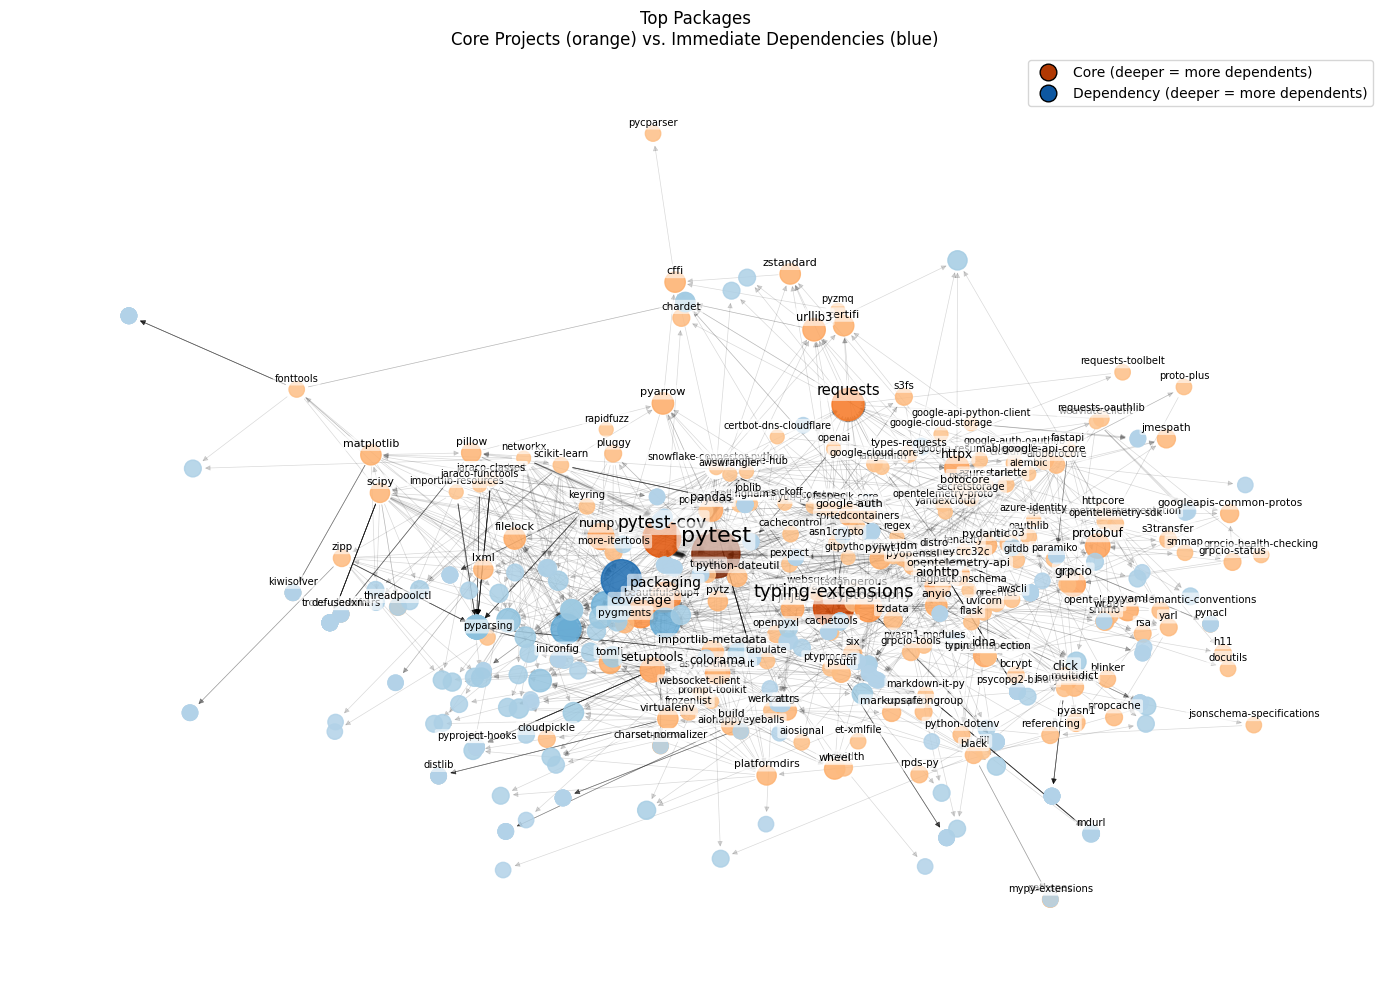

In [6]:
def get_core_and_degrees(G):
    core_nodes = [n for n, d in G.nodes(data=True) if d.get("core", False)]
    in_degrees = dict(G.in_degree())
    min_deg, max_deg = (min(in_degrees.values()), max(in_degrees.values())) if in_degrees else (0, 1)
    return core_nodes, in_degrees, min_deg, max_deg

def get_node_color_and_size_funcs(core_nodes, in_degrees, min_deg, max_deg, core_cmap, dep_cmap):
    def norm(deg):
        return 0.7 if max_deg == min_deg else 0.3 + 0.7 * (deg - min_deg) / (max_deg - min_deg)
    def get_color(n):
        return core_cmap(norm(in_degrees.get(n, 0))) if n in core_nodes else dep_cmap(norm(in_degrees.get(n, 0)))
    def get_size(n, min_size=100, max_size=1200):
        deg = in_degrees.get(n, 0)
        return (min_size + max_size) // 2 if max_deg == min_deg else min_size + (max_size - min_size) * (deg - min_deg) / (max_deg - min_deg)
    return get_color, get_size

def push_big_nodes_outward(pos, in_degrees, push_factor=1.35, top_n=3):
    if not in_degrees: return pos
    top_nodes = sorted(in_degrees, key=in_degrees.get, reverse=True)[:top_n]
    xs, ys = zip(*pos.values())
    centroid = (sum(xs) / len(xs), sum(ys) / len(ys))
    for n in top_nodes:
        x, y = pos[n]
        dx, dy = x - centroid[0], y - centroid[1]
        if dx == 0 and dy == 0:
            dx, dy = np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1)
        pos[n] = (x + dx * (push_factor - 1), y + dy * (push_factor - 1))
    return pos

def get_layout(G, in_degrees):
    try:
        pos = nx.kamada_kawai_layout(G, weight=None, scale=2.5, dim=2)
        pos = push_big_nodes_outward(pos, in_degrees)
    except Exception:
        pos = nx.spring_layout(G, k=2.5/np.sqrt(G.number_of_nodes()), iterations=200, seed=42, scale=2.5, weight=None)
    return pos

def get_label_positions(core_nodes, pos, in_degrees, node_size_dict, node_sizes):
    core_labels = {n: n for n in core_nodes}
    rounded_pos = {n: (round(x, 4), round(y, 4)) for n, (x, y) in pos.items()}
    pos_to_nodes = defaultdict(list)
    for n, xy in rounded_pos.items():
        pos_to_nodes[xy].append(n)
    label_pos = {}
    max_size = max(node_sizes) if node_sizes else 1
    for n in core_labels:
        x, y = pos[n]
        xy = rounded_pos[n]
        nodes_here = pos_to_nodes[xy]
        n_deg = in_degrees.get(n, 0)
        num_lower = sum(1 for other in nodes_here if in_degrees.get(other, 0) < n_deg)
        shift = 0.03 + 0.01 * (node_size_dict[n] / max_size) + 0.025 * num_lower
        label_pos[n] = (x, y + shift)
    return core_labels, label_pos

def get_label_fontsize_func(in_degrees, min_deg, max_deg):
    def get_label_fontsize(n, min_fontsize=7, max_fontsize=16):
        deg = in_degrees.get(n, 0)
        return (min_fontsize + max_fontsize) / 2 if max_deg == min_deg else min_fontsize + (max_fontsize - min_fontsize) * (deg - min_deg) / (max_deg - min_deg)
    return get_label_fontsize

def plot_core_dependency_graph(G, title):
    core_cmap, dep_cmap = plt.get_cmap("Oranges"), plt.get_cmap("Blues")
    core_nodes, in_degrees, min_deg, max_deg = get_core_and_degrees(G)
    get_color, get_size = get_node_color_and_size_funcs(core_nodes, in_degrees, min_deg, max_deg, core_cmap, dep_cmap)
    node_colors = [get_color(n) for n in G.nodes()]
    node_sizes = [get_size(n) for n in G.nodes()]
    node_size_dict = dict(zip(G.nodes(), node_sizes))
    pos = get_layout(G, in_degrees)
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.15, arrowsize=8, width=0.5)
    core_labels, label_pos = get_label_positions(core_nodes, pos, in_degrees, node_size_dict, node_sizes)
    get_label_fontsize = get_label_fontsize_func(in_degrees, min_deg, max_deg)
    for n in sorted(core_labels, key=lambda n: in_degrees.get(n, 0)):
        lx, ly = label_pos[n]
        plt.text(
            lx, ly, n,
            fontsize=get_label_fontsize(n),
            color="black",
            ha="center",
            va="bottom",
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
        )
    plt.title(title)
    plt.axis("off")
    plt.legend(handles=[
        Line2D([0], [0], marker='o', color='w', label='Core (deeper = more dependents)', markerfacecolor=core_cmap(0.85), markersize=12, markeredgecolor='k'),
        Line2D([0], [0], marker='o', color='w', label='Dependency (deeper = more dependents)', markerfacecolor=dep_cmap(0.85), markersize=12, markeredgecolor='k')
    ], scatterpoints=1)
    plt.tight_layout()
    plt.show()

plot_core_dependency_graph(G_top, "Top Packages\nCore Projects (orange) vs. Immediate Dependencies (blue)")

### Recent Packages

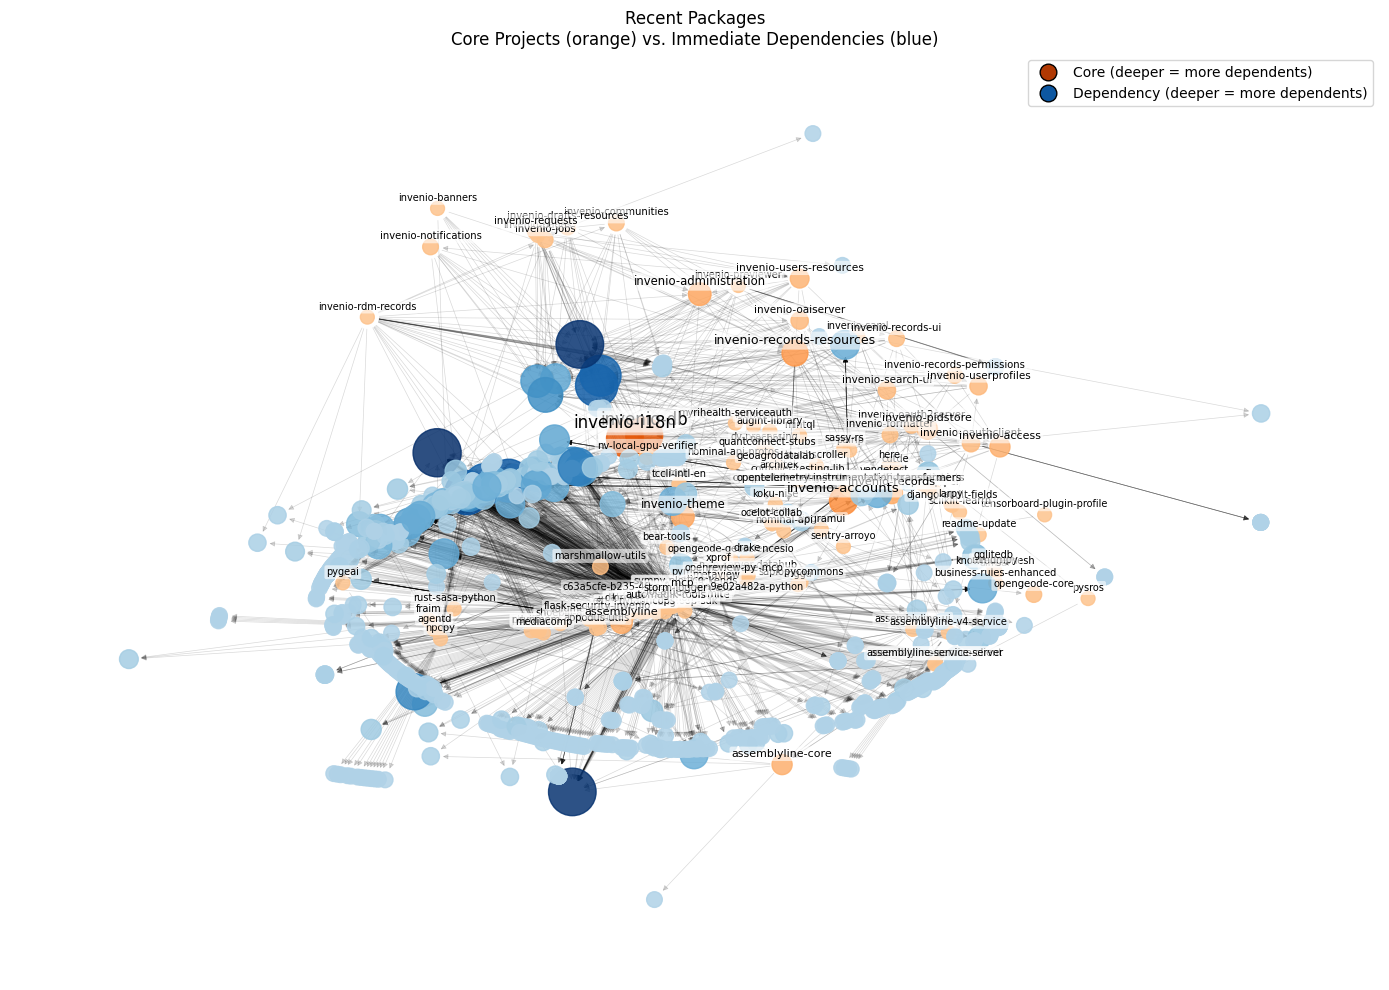

In [7]:
plot_core_dependency_graph(G_recent, "Recent Packages\nCore Projects (orange) vs. Immediate Dependencies (blue)")

## **Dependencies (Edges)**

### Common Dependencies

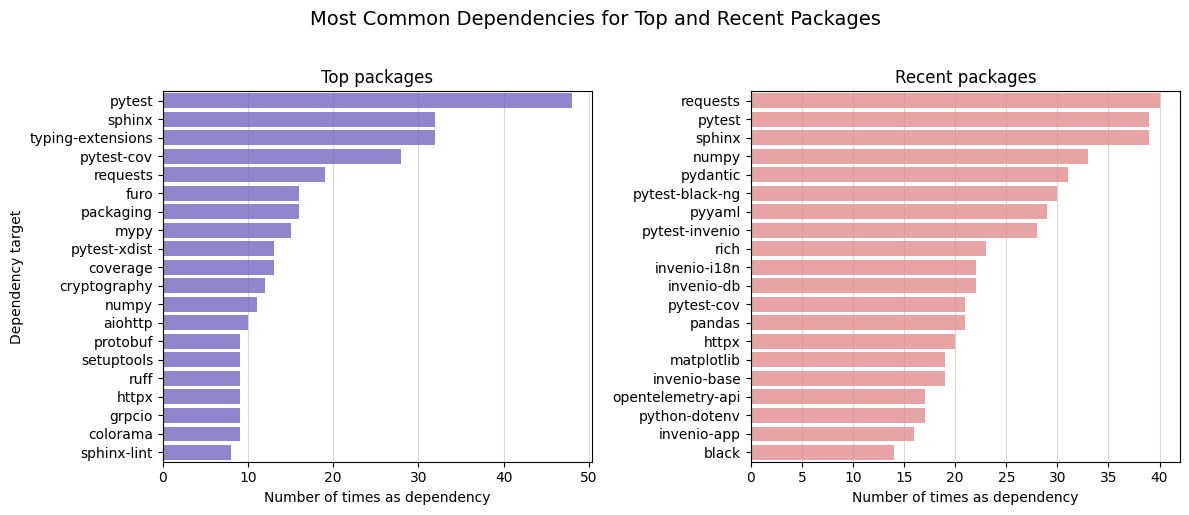

In [8]:
n = 20

top_common_targets = df_edges_top["target"].value_counts().head(n)
recent_common_targets = df_edges_recent["target"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    y=top_common_targets.index,
    x=top_common_targets.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as dependency")
axes[0].set_ylabel("Dependency target")
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_common_targets.index,
    x=recent_common_targets.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as dependency")
axes[1].set_ylabel("")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

fig.suptitle("Most Common Dependencies for Top and Recent Packages", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Most Dependencies

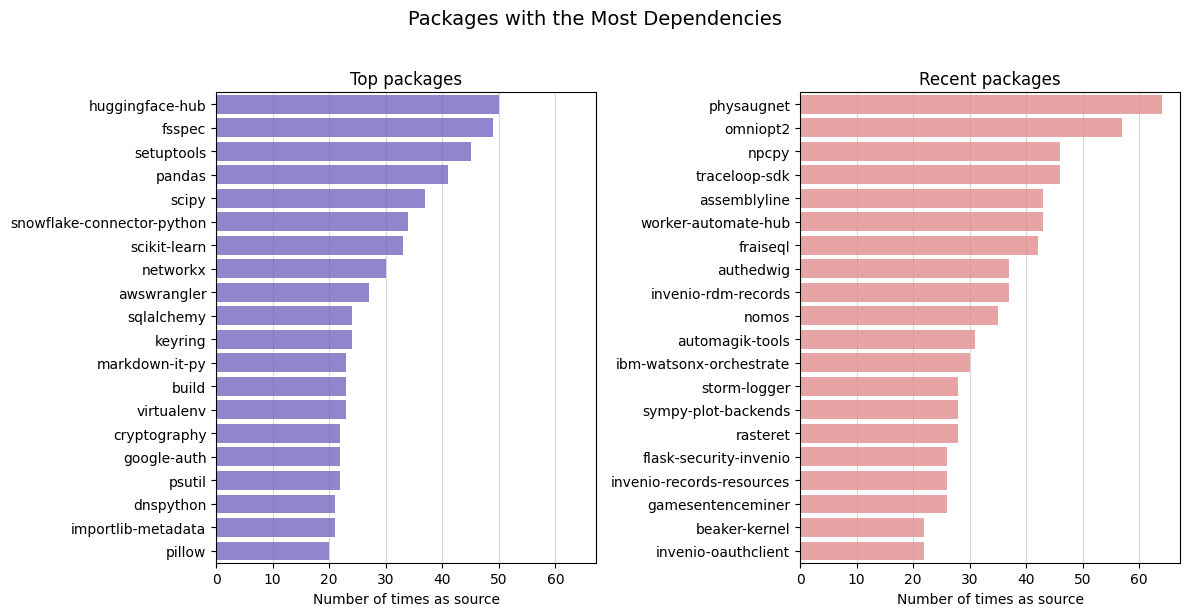

In [9]:
n = 20
top_sources = df_edges_top["source"].value_counts().head(n)
recent_sources = df_edges_recent["source"].value_counts().head(n)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.barplot(
    y=top_sources.index,
    x=top_sources.values,
    ax=axes[0],
    color=color_top,
    orient="h",
    alpha=0.8
)
axes[0].set_xlabel("Number of times as source")
axes[0].set_ylabel(None)
axes[0].set_title("Top packages")

sns.barplot(
    y=recent_sources.index,
    x=recent_sources.values,
    ax=axes[1],
    color=color_recent,
    orient="h",
    alpha=0.8
)
axes[1].set_xlabel("Number of times as source")
axes[1].set_ylabel(None)
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax)

# Add grid lines
fig.suptitle("Packages with the Most Dependencies", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Optional Dependency Proportions

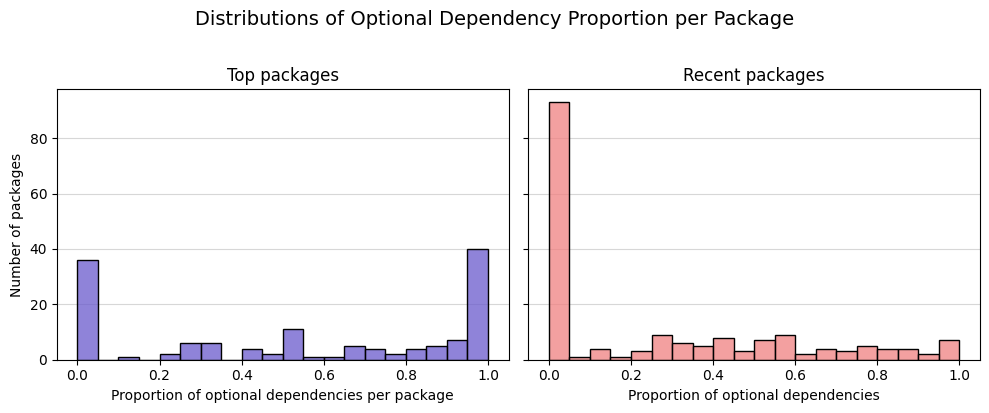

In [10]:
# Compute proportion of optional dependencies per source package for both DataFrames
prop_top = (
    df_edges_top.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)
prop_recent = (
    df_edges_recent.groupby("source")["optional"]
    .apply(lambda x: (x == True).mean())
    .sort_values(ascending=False)
)

# Top packages
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
sns.histplot(prop_top, bins=20, color=color_top, kde=False, ax=axes[0])
axes[0].set_xlabel("Proportion of optional dependencies per package")
axes[0].set_ylabel("Number of packages")
axes[0].set_title("Top packages")

# Recent packages
sns.histplot(prop_recent, bins=20, color=color_recent, kde=False, ax=axes[1])
axes[1].set_xlabel("Proportion of optional dependencies")
axes[1].set_title("Recent packages")

for ax in axes:
    add_grid(ax, "y")

fig.suptitle("Distributions of Optional Dependency Proportion per Package", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

* pytest and requests are common dependencies.
* Top packages have a more skewed distribution with fewer dependencies in general.
* Top packages are notably less likely to have no optional dependencies, and more likely to have only optional dependencies.
* fsspec stands out as having the most dependencies among the top packages at 50.
  * A high number of dependencies such as this may be anomalous for less established packages.

## **Projects (Nodes)**

### Extract Node Features

In [11]:
def get_core_nodes_df(G):
    df = pd.DataFrame([
        {"name": node, **data}
        for node, data in G.nodes(data=True) if data.get("core")
    ])
    if "latest_release" in df.columns:
        df["latest_release"] = pd.to_datetime(df["latest_release"], errors="coerce")
    return df

df_nodes_top = get_core_nodes_df(G_top)
df_nodes_recent = get_core_nodes_df(G_recent)

### Package Metadata Overview

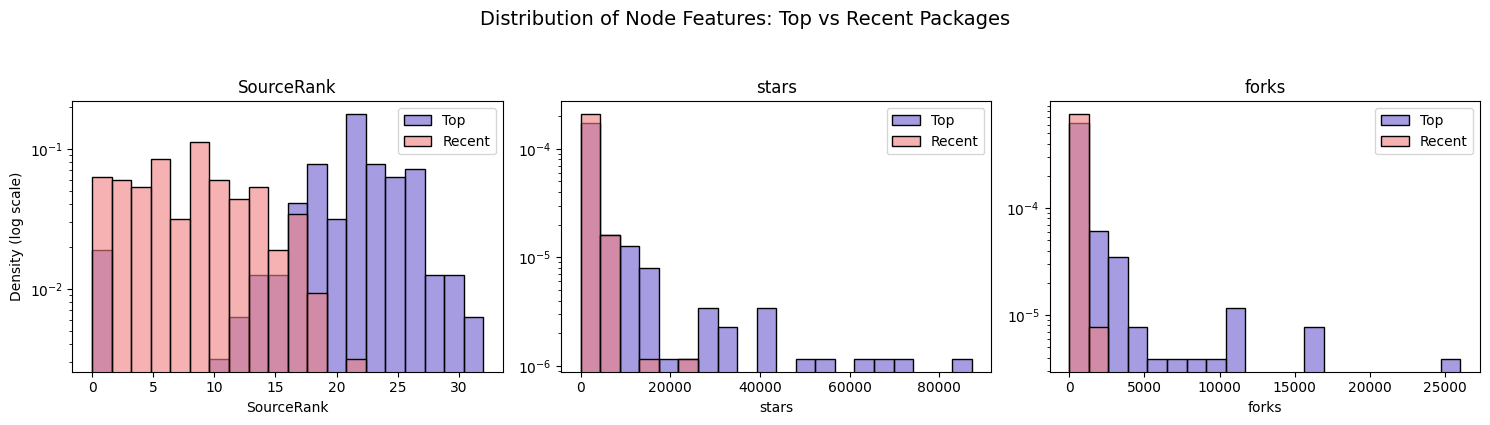

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features = ["SourceRank", "stars", "forks"]

for i, feature in enumerate(features):
    # Compute min and max for both datasets to get consistent bin edges
    data_top = df_nodes_top[feature]
    data_recent = df_nodes_recent[feature]
    data_all = pd.concat([data_top, data_recent])
    min_val = data_all.min()
    max_val = data_all.max()

    # Use 20 bins
    bin_width = (max_val - min_val) / 20 if max_val > min_val else 1
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    sns.histplot(data_top, bins=bins, color=colors[0], label="Top", ax=axes[i], alpha=0.6, stat="density")
    sns.histplot(data_recent, bins=bins, color=colors[1], label="Recent", ax=axes[i], alpha=0.6, stat="density")
    axes[i].set_title(features[i])
    axes[i].set_xlabel(feature)
    axes[i].set_yscale("log")  # Set y-axis to log scale
    if i == 0:
        axes[i].set_ylabel("Density (log scale)")
    else:
        axes[i].set_ylabel("")
    axes[i].legend()

fig.suptitle("Distribution of Node Features: Top vs Recent Packages", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

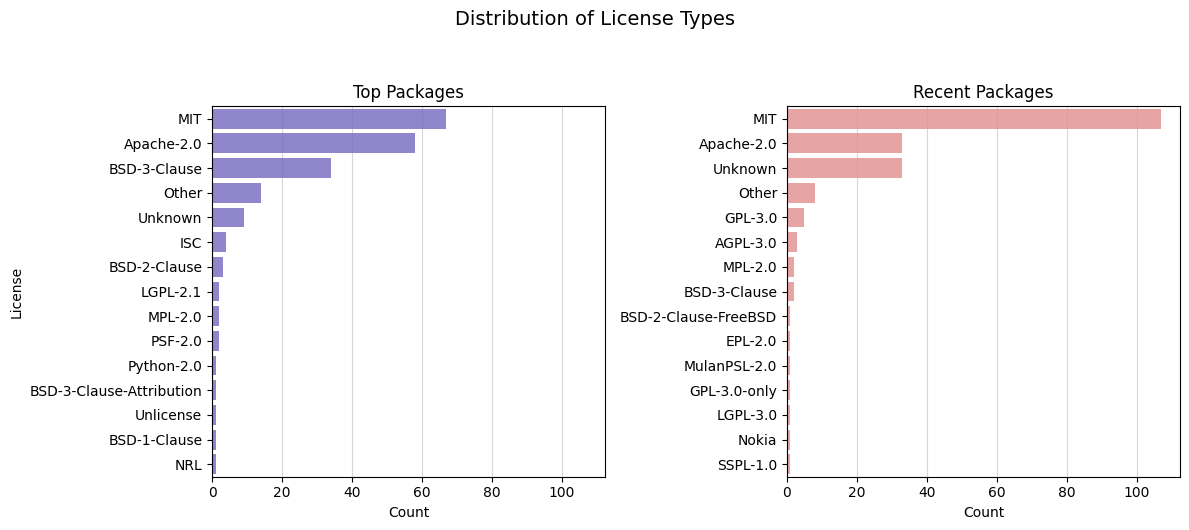

In [13]:
# Plot and compare license value counts for df_nodes_top and df_nodes_recent

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Top packages
license_counts_top = df_nodes_top["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_top.values, y=license_counts_top.index, ax=axes[0], color=color_top, alpha=0.8)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("License")

# Recent packages
license_counts_recent = df_nodes_recent["license"].value_counts().sort_values(ascending=False)
sns.barplot(x=license_counts_recent.values, y=license_counts_recent.index, ax=axes[1], color=color_recent, alpha=0.8)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

for ax in axes:
    add_grid(ax)

fig.suptitle("Distribution of License Types", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### SourceRank Metric Correlation

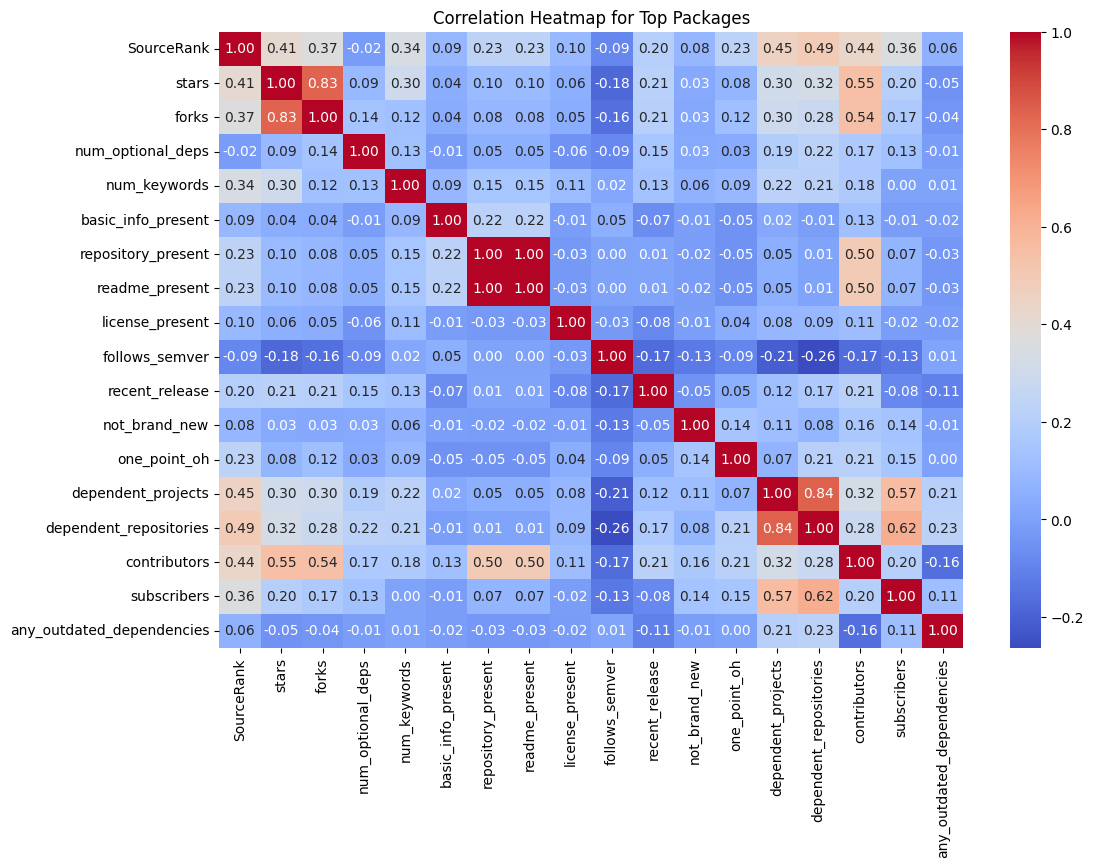

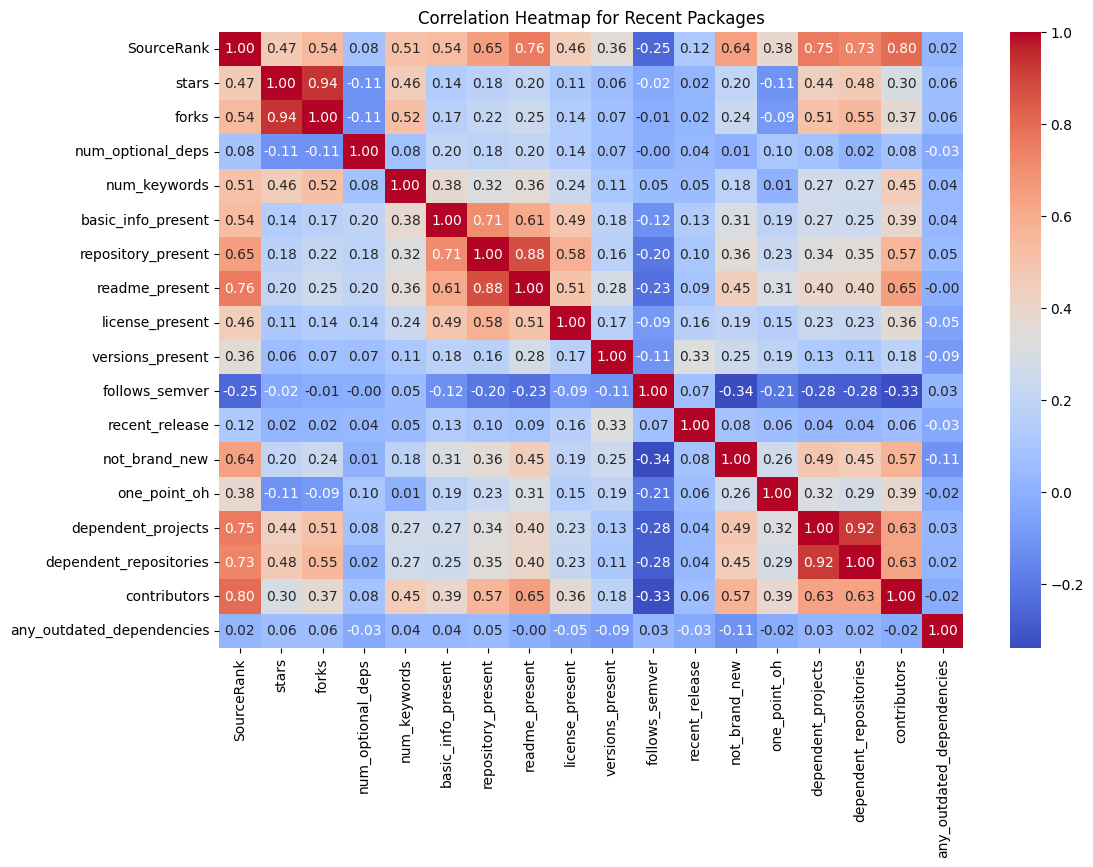

In [14]:
def plot_correlation_heatmap(df, title, figsize=(12, 8)):
    numeric_cols = df.select_dtypes(include=["int64", "float64"])
    corr = numeric_cols.corr().dropna(axis=0, how="all").dropna(axis=1, how="all")
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(title)
    plt.show()

plot_correlation_heatmap(df_nodes_top, "Correlation Heatmap for Top Packages")
plot_correlation_heatmap(df_nodes_recent, "Correlation Heatmap for Recent Packages")


### Copycats (Projects in Same Repo)

In [15]:
def get_copycat_repo_details(df):
    copycats = df[(df["is_copycat"])]
    if copycats.empty:
        return copycats

    # Group by repo_url and aggregate details
    grouped = (
        copycats
        .groupby("repo_url", as_index=False)
        .agg(
            count=("name", "size"),
            name=("name", lambda x: ", ".join(sorted(set(x)))),
            stars=("stars", "max"),
            forks=("forks", "max")
        )
        .sort_values(["count", "repo_url"], ascending=[False, True])
    )
    return grouped

top_copycat_details = get_copycat_repo_details(df_nodes_top)
recent_copycat_details = get_copycat_repo_details(df_nodes_recent)

print("Top packages with shared repository url and metadata:")
display(top_copycat_details)

print("\nRecent packages with shared repository url and metadata:")
display(recent_copycat_details)

Top packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
3,https://github.com/open-telemetry/opentelemetr...,4,"opentelemetry-api, opentelemetry-proto, opente...",2068,717
0,https://github.com/Azure/azure-sdk-for-python,2,"azure-core, azure-identity",4988,3045
1,https://github.com/certbot/certbot,2,"acme, certbot-dns-cloudflare",32247,3429
2,https://github.com/grpc/grpc,2,"grpcio, grpcio-tools",43324,10849



Recent packages with shared repository url and metadata:


,repo_url,count,name,stars,forks
1,https://github.com/traceloop/openllmetry,13,"opentelemetry-instrumentation-ollama, opentele...",6093,761
0,https://github.com/openxla/xprof,2,"tensorboard-plugin-profile, xprof",398,67


## **Graph Structure**

### Degree Distributions

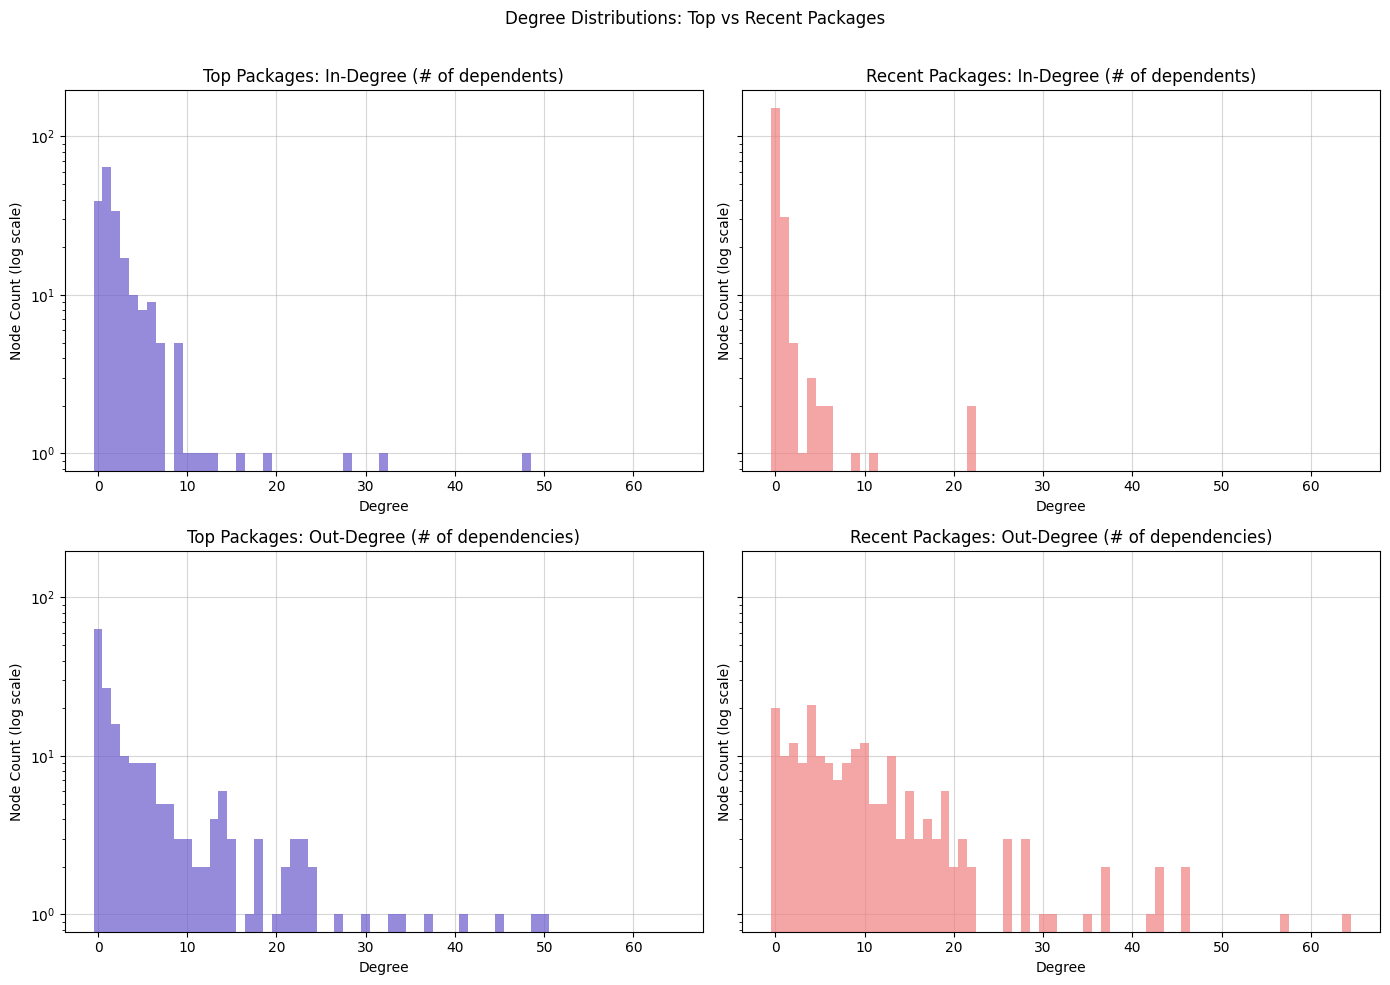

In [16]:
def plot_degree_comparison_core_only(G_top, G_recent, color_top, color_recent, title_prefix=""):
    def degree_lists_core(G):
        # Only include nodes where core=True
        core_nodes = [n for n, d in G.nodes(data=True) if d.get("core", False)]
        in_deg = [G.in_degree(n) for n in core_nodes]
        out_deg = [G.out_degree(n) for n in core_nodes]
        return in_deg, out_deg

    in_deg_top, out_deg_top = degree_lists_core(G_top)
    in_deg_recent, out_deg_recent = degree_lists_core(G_recent)

    # Combine all degrees to get global min/max for binning
    all_degrees = in_deg_top + in_deg_recent + out_deg_top + out_deg_recent
    if not all_degrees:
        print("No core nodes found in either graph.")
        return
    deg_min, deg_max = min(all_degrees), max(all_degrees)
    bins = np.arange(deg_min, deg_max + 2) - 0.5  # so each integer is its own bin

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

    # Prepare data and labels for each subplot to avoid repetition
    plot_configs = [
        # (row, col, data, color, title)
        (0, 0, in_deg_top, color_top, "Top Packages: In-Degree (# of dependents)"),
        (0, 1, in_deg_recent, color_recent, "Recent Packages: In-Degree (# of dependents)"),
        (1, 0, out_deg_top, color_top, "Top Packages: Out-Degree (# of dependencies)"),
        (1, 1, out_deg_recent, color_recent, "Recent Packages: Out-Degree (# of dependencies)"),
    ]

    for row, col, data, color, title in plot_configs:
        ax = axes[row, col]
        ax.hist(data, bins=bins, color=color, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Degree")
        ax.set_ylabel("Node Count (log scale)")
        ax.set_yscale("log")
        add_grid(ax, "y")
        add_grid(ax, "x")

    plt.suptitle(title_prefix)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_degree_comparison_core_only(
    G_top, G_recent, color_top, color_recent,
    title_prefix="Degree Distributions: Top vs Recent Packages"
)


### Clustering Coefficient

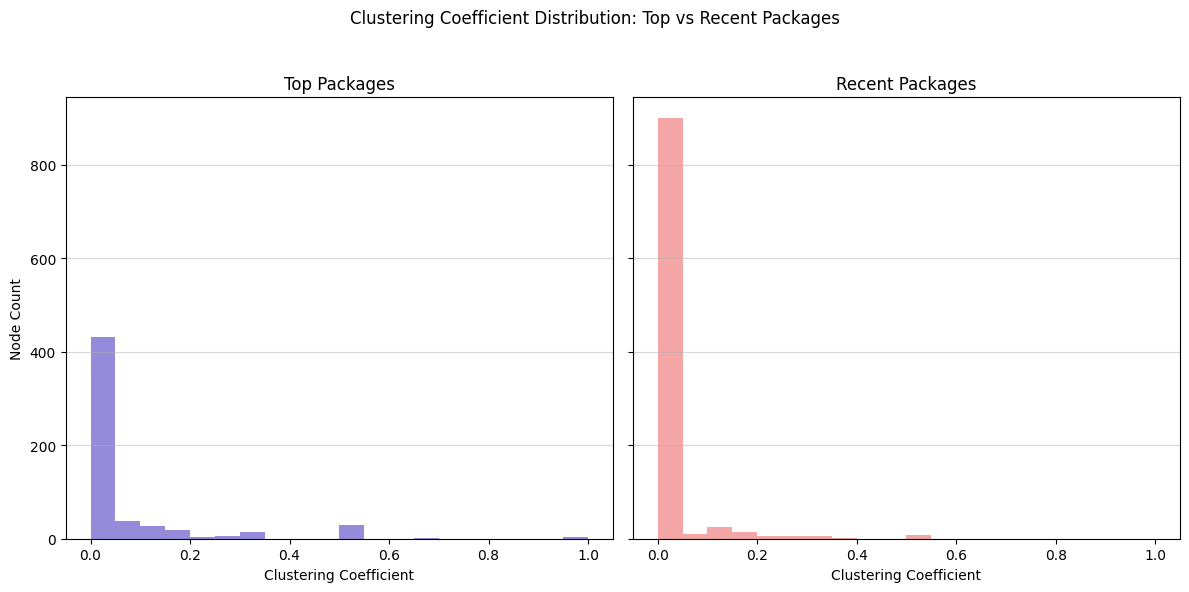

In [17]:
# Compute clustering coefficients for each node in both graphs
clustering_top = nx.clustering(G_top)
clustering_recent = nx.clustering(G_recent)

# Extract coefficient values
coeffs_top = list(clustering_top.values())
coeffs_recent = list(clustering_recent.values())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
bins = np.linspace(0, 1, 21)

axes[0].hist(coeffs_top, bins=bins, alpha=0.7, color=color_top)
axes[0].set_title("Top Packages")
axes[0].set_xlabel("Clustering Coefficient")
axes[0].set_ylabel("Node Count")
axes[0].grid(axis="y", alpha=0.5)

axes[1].hist(coeffs_recent, bins=bins, alpha=0.7, color=color_recent)
axes[1].set_title("Recent Packages")
axes[1].set_xlabel("Clustering Coefficient")
axes[1].grid(axis="y", alpha=0.5)

plt.suptitle("Clustering Coefficient Distribution: Top vs Recent Packages")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Centrality Measures

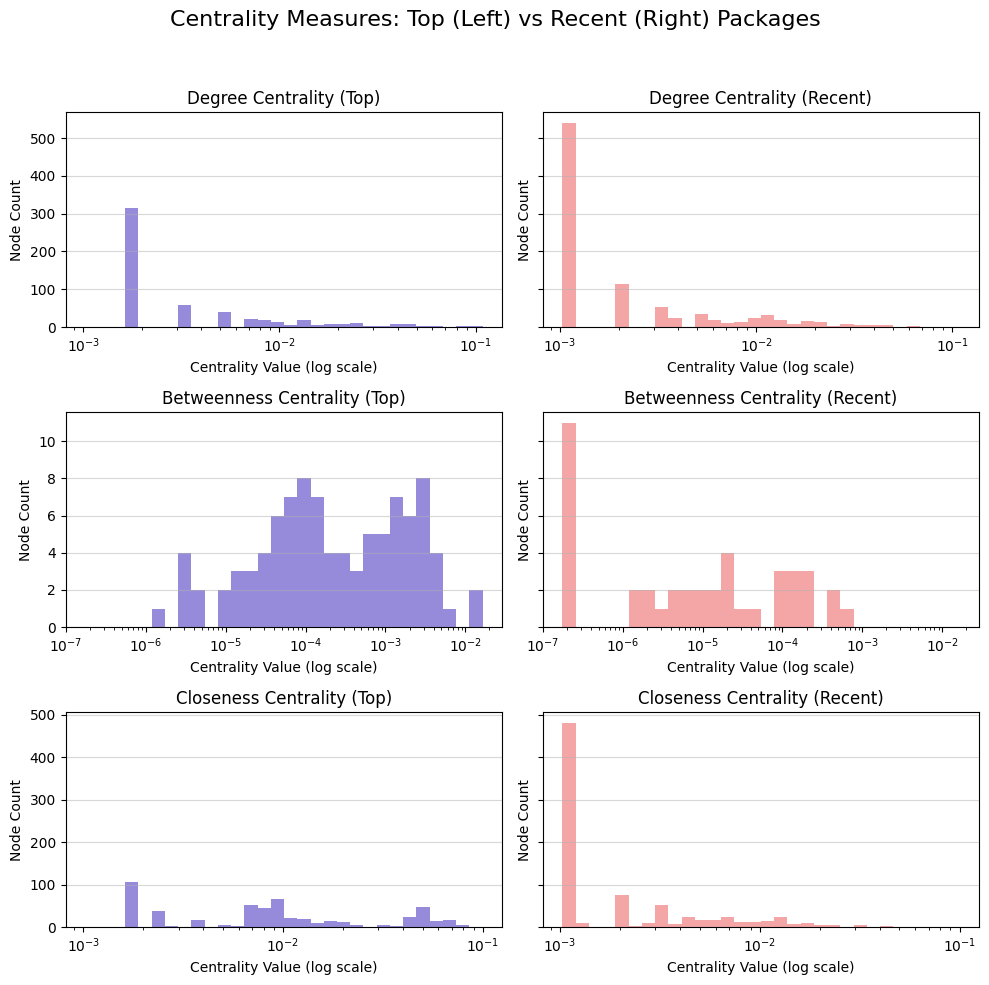

In [18]:
degree_top = nx.degree_centrality(G_top)
degree_recent = nx.degree_centrality(G_recent)

betweenness_top = nx.betweenness_centrality(G_top)
betweenness_recent = nx.betweenness_centrality(G_recent)

closeness_top = nx.closeness_centrality(G_top)
closeness_recent = nx.closeness_centrality(G_recent)

centrality_measures = [
    ("Degree", degree_top, degree_recent),
    ("Betweenness", betweenness_top, betweenness_recent),
    ("Closeness", closeness_top, closeness_recent),
]

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey='row', sharex="row")

for i, (name, top_dict, recent_dict) in enumerate(centrality_measures):
    top_vals = np.array(list(top_dict.values()))
    recent_vals = np.array(list(recent_dict.values()))
    top_vals = top_vals[top_vals > 0]
    recent_vals = recent_vals[recent_vals > 0]

    all_values = np.concatenate([top_vals, recent_vals])
    if all_values.size == 0:
        bins = 10
    else:
        min_val = all_values.min()
        max_val = all_values.max()
        if min_val == max_val:
            bins = 10
        else:
            # Use logspace for bins
            bins = np.logspace(np.log10(min_val), np.log10(max_val), 31)

    # Left column: Top
    axes[i, 0].hist(
        top_vals, bins=bins, alpha=0.7, color=color_top
    )
    axes[i, 0].set_title(f"{name} Centrality (Top)")
    axes[i, 0].set_xlabel("Centrality Value (log scale)")
    axes[i, 0].set_ylabel("Node Count")
    axes[i, 0].grid(axis="y", alpha=0.5)
    axes[i, 0].set_xscale("log")

    # Right column: Recent
    axes[i, 1].hist(
        recent_vals, bins=bins, alpha=0.7, color=color_recent
    )
    axes[i, 1].set_title(f"{name} Centrality (Recent)")
    axes[i, 1].set_xlabel("Centrality Value (log scale)")
    axes[i, 1].set_ylabel("Node Count")
    axes[i, 1].grid(axis="y", alpha=0.5)
    axes[i, 1].set_xscale("log")

plt.suptitle("Centrality Measures: Top (Left) vs Recent (Right) Packages", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Community Detection and Outliers

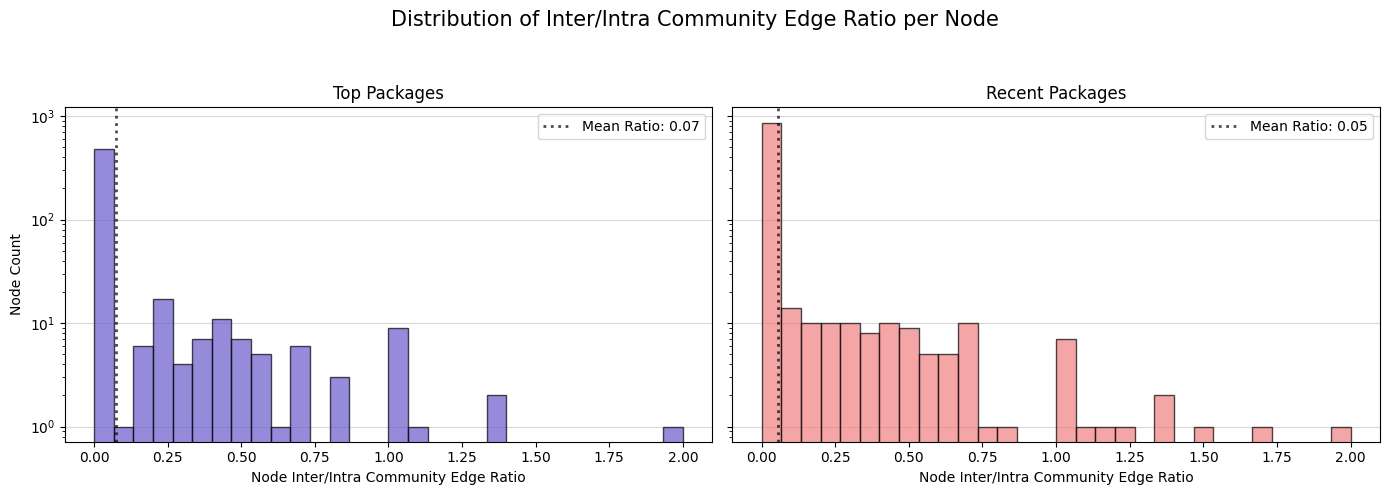

In [19]:
def compute_inter_intra_ratios(G):
    comms = list(greedy_modularity_communities(G))
    node2comm = {n: i for i, c in enumerate(comms) for n in c}
    ratios = []
    for node in G.nodes():
        comm = node2comm.get(node)
        if comm is None: continue
        intra = sum(node2comm.get(nb) == comm for nb in G.neighbors(node))
        inter = sum(node2comm.get(nb) != comm for nb in G.neighbors(node))
        ratios.append(float("inf") if intra == 0 and inter > 0 else (inter / intra if intra else 0))
    return ratios

ratios_top = compute_inter_intra_ratios(G_top)
ratios_recent = compute_inter_intra_ratios(G_recent)
finite_top = [r for r in ratios_top if np.isfinite(r)]
finite_recent = [r for r in ratios_recent if np.isfinite(r)]

all_finite = np.concatenate([finite_top, finite_recent])
if all_finite.size:
    minr, maxr = all_finite.min(), all_finite.max()
    bins = 10 if minr == maxr else np.linspace(minr, maxr, 31)
else:
    bins = 10

mean_top = np.mean(finite_top) if finite_top else 0
mean_recent = np.mean(finite_recent) if finite_recent else 0

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for ax, vals, color, title, mean_val in zip(
    axes, [finite_top, finite_recent], [color_top, color_recent], ["Top Packages", "Recent Packages"], [mean_top, mean_recent]
):
    ax.hist(vals, bins=bins, color=color, edgecolor="k", alpha=0.7)
    ax.axvline(mean_val, color="black", linestyle=":", linewidth=2, label=f"Mean Ratio: {mean_val:.2f}", alpha=0.7)
    ax.set_xlabel("Node Inter/Intra Community Edge Ratio")
    ax.set_title(title)
    ax.set_yscale("log")
    add_grid(ax, "y")
    ax.legend()
axes[0].set_ylabel("Node Count")
plt.suptitle("Distribution of Inter/Intra Community Edge Ratio per Node", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### SourceRank/Structure Feature Comparison

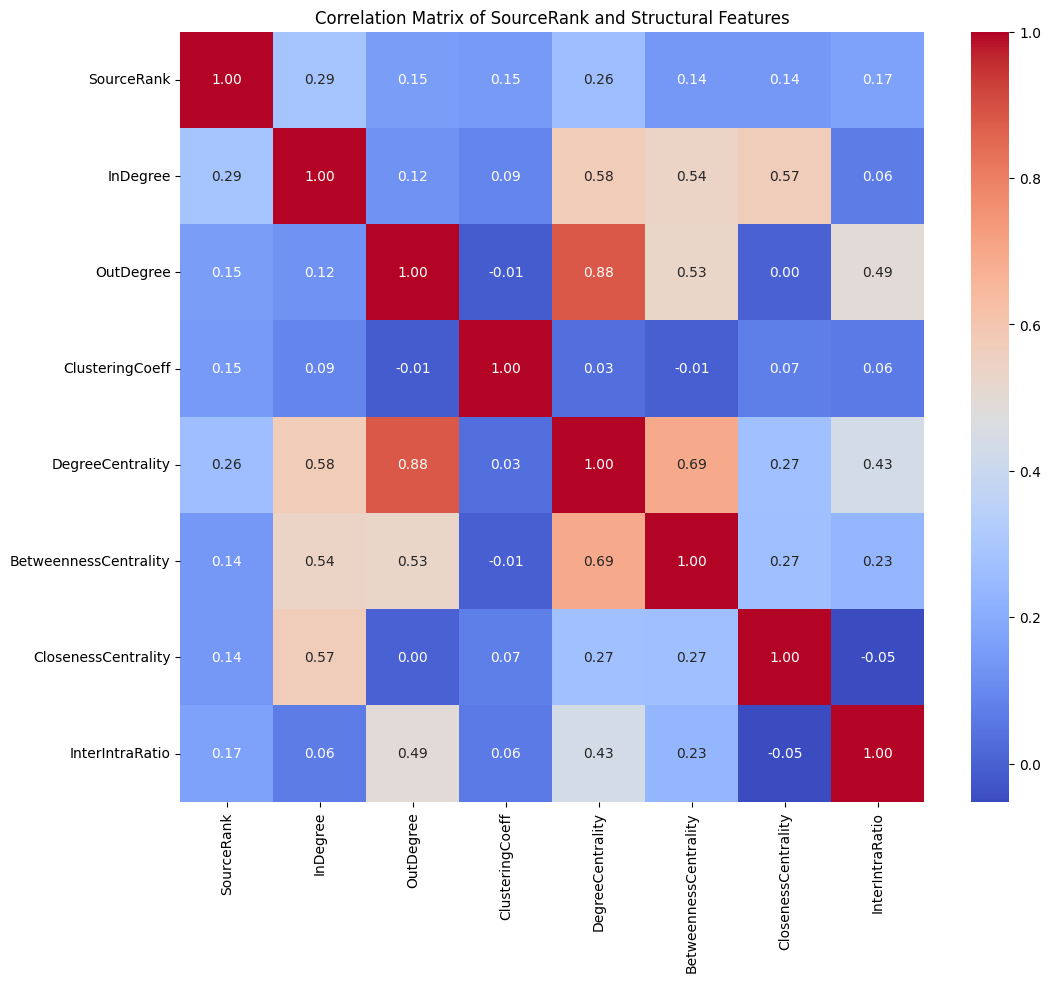

In [20]:
def plot_sourcerank_structural_features(
    G, degree_centrality=None, betweenness=None,
    closeness=None, clustering=None, inter_intra_ratios=None
):
    nodes = list(G.nodes())
    get_val = lambda d, n, i: (d.get(n, np.nan) if isinstance(d, dict) else (d[i] if d is not None and i < len(d) else np.nan))
    data = [{
        "SourceRank": G.nodes[n].get("SourceRank", np.nan),
        "InDegree": G.in_degree(n) if hasattr(G, "in_degree") else np.nan,
        "OutDegree": G.out_degree(n) if hasattr(G, "out_degree") else np.nan,
        "ClusteringCoeff": get_val(clustering, n, i),
        "DegreeCentrality": get_val(degree_centrality, n, i),
        "BetweennessCentrality": get_val(betweenness, n, i),
        "ClosenessCentrality": get_val(closeness, n, i),
        "InterIntraRatio": (
            inter_intra_ratios.get(n, np.nan) if isinstance(inter_intra_ratios, dict)
            else (inter_intra_ratios[i] if inter_intra_ratios is not None and i < len(inter_intra_ratios) else np.nan)
        )
    } for i, n in enumerate(nodes)]
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of SourceRank and Structural Features")
    plt.show()

    return df

df_scatter_top = plot_sourcerank_structural_features(
    G_top,
    degree_centrality=degree_top,
    betweenness=betweenness_top,
    closeness=closeness_top,
    clustering=clustering_top,
    inter_intra_ratios=ratios_top,
)

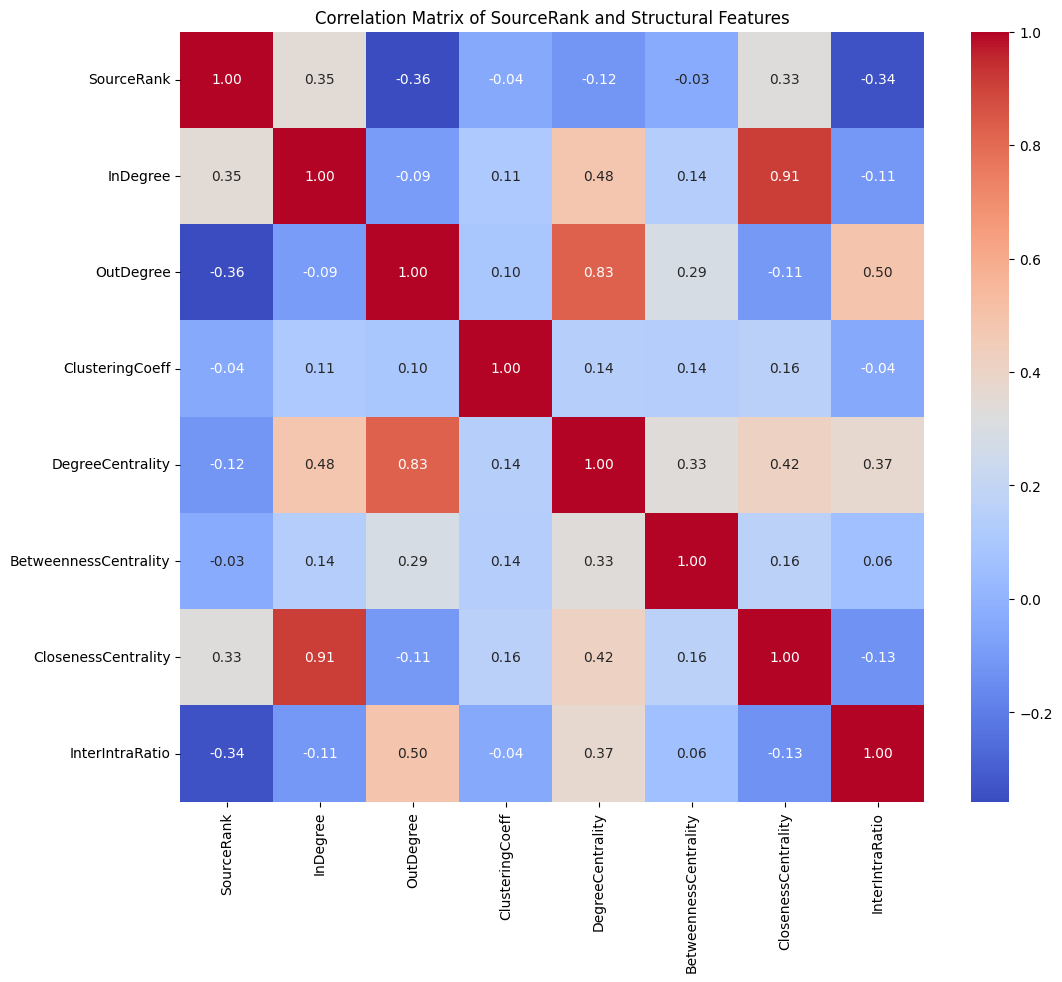

In [21]:
df_scatter_recent = plot_sourcerank_structural_features(
    G_recent,
    degree_centrality=degree_recent,
    betweenness=betweenness_recent,
    closeness=closeness_recent,
    clustering=clustering_recent,
    inter_intra_ratios=ratios_recent,
)

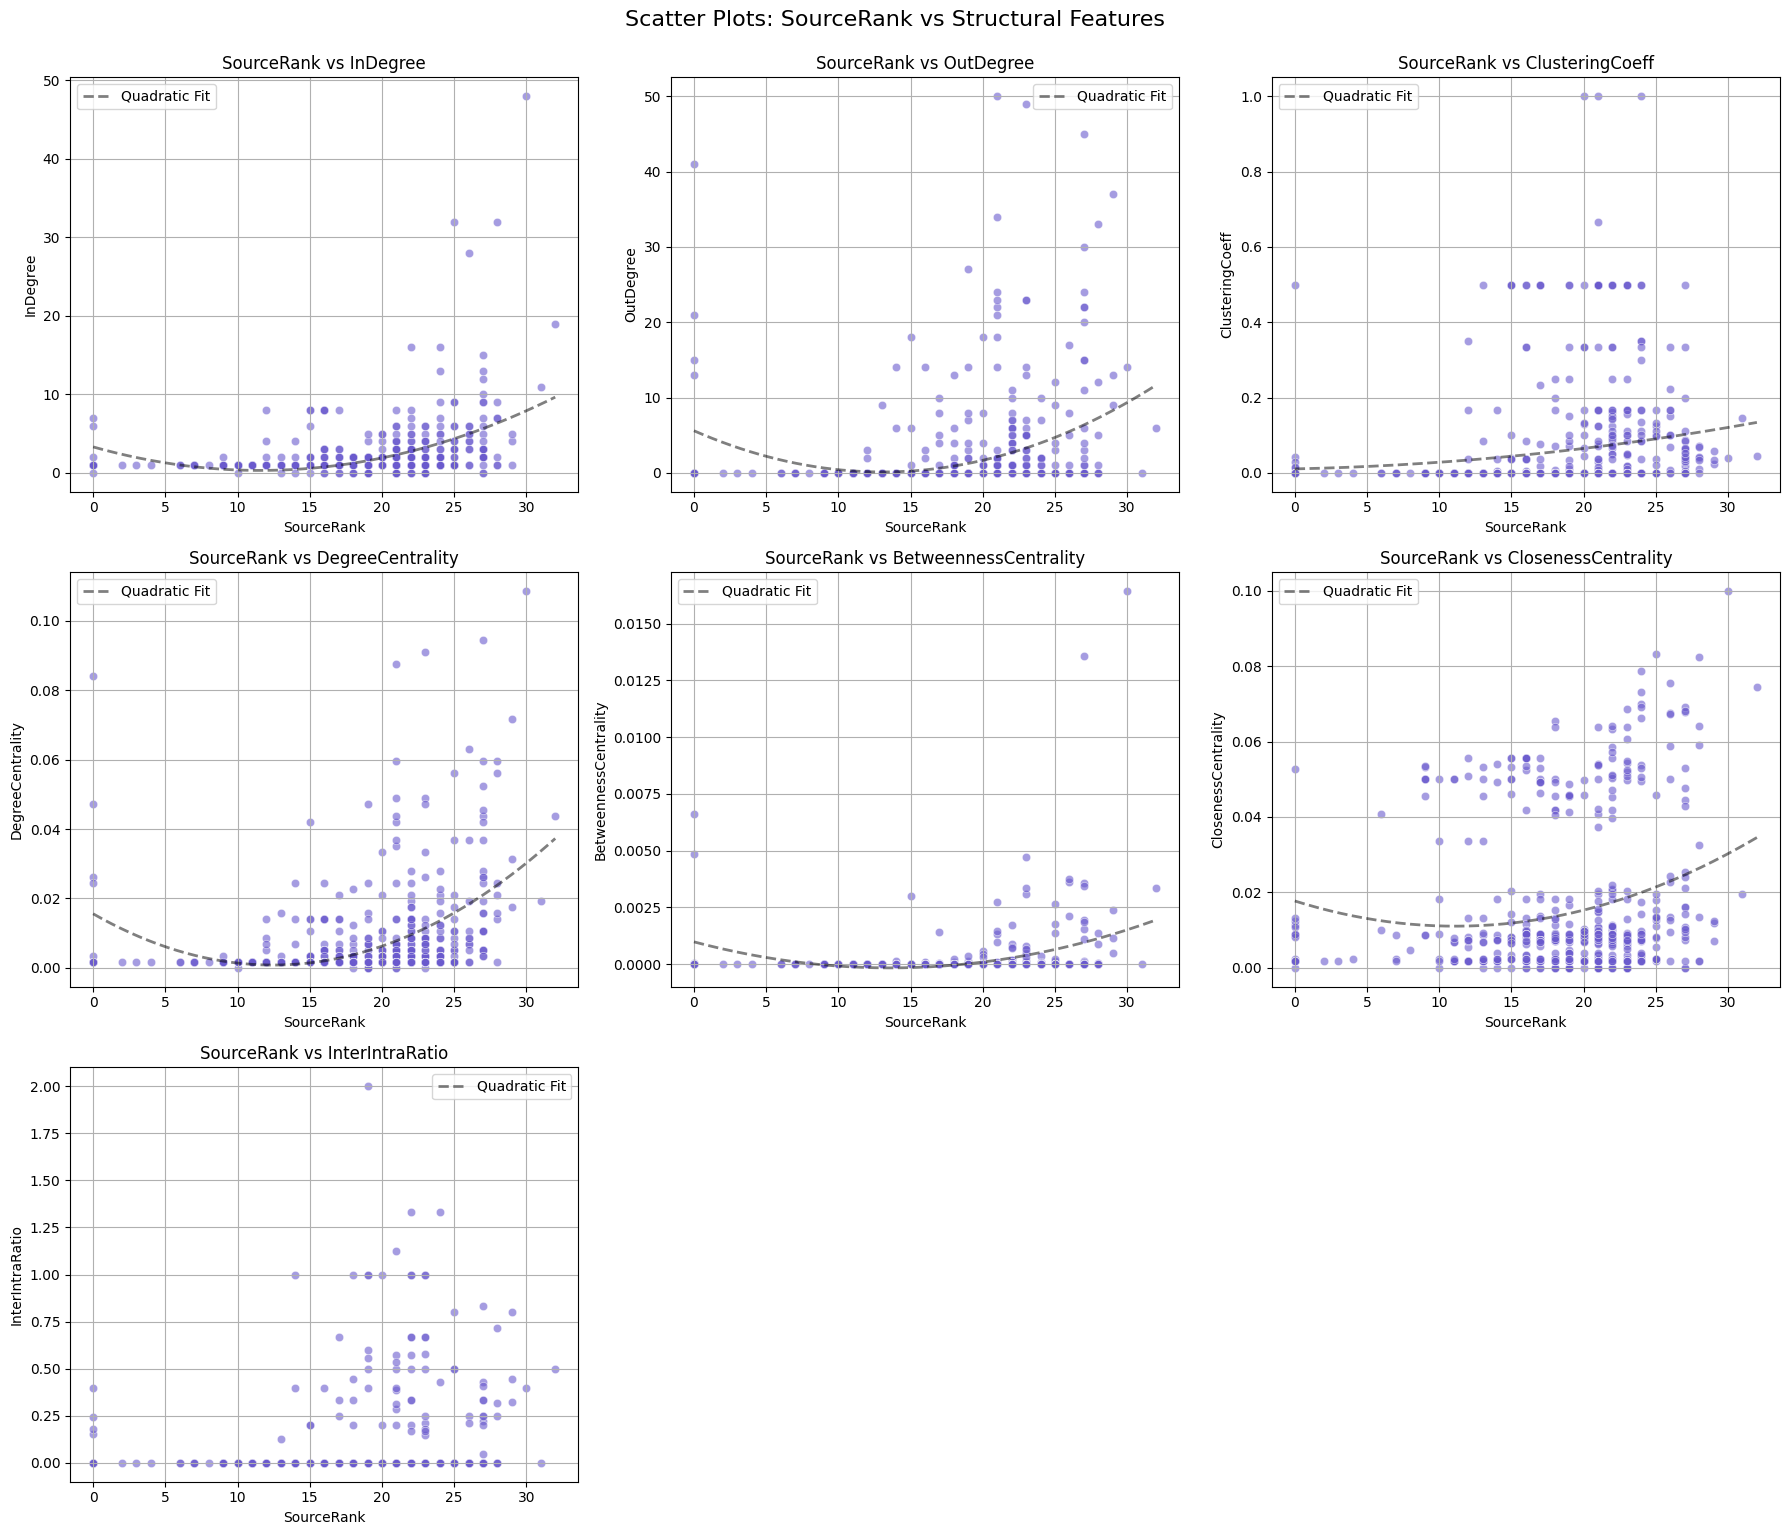

In [22]:
def plot_sourcerank_scatter_matrix(df, color):
    features = [
        "InDegree", "OutDegree", "ClusteringCoeff", "DegreeCentrality",
        "BetweennessCentrality", "ClosenessCentrality", "InterIntraRatio"
    ]
    n_cols = 3
    n_rows = int(np.ceil(len(features)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.scatterplot(x="SourceRank", y=feature, data=df, ax=axes[i], alpha=0.6, color=color)
        # Fit and plot 2nd degree polynomial
        x = df["SourceRank"].values
        y = df[feature].values
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 2:
            coeffs = np.polyfit(x[mask], y[mask], 2)
            poly = np.poly1d(coeffs)
            x_fit = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 200)
            y_fit = poly(x_fit)
            axes[i].plot(x_fit, y_fit, color="black", linestyle="--", linewidth=2, alpha=0.5, label="Quadratic Fit")
            axes[i].legend()
        axes[i].set_title(f"SourceRank vs {feature}")
        axes[i].grid(True)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.suptitle("Scatter Plots: SourceRank vs Structural Features", y=1.02, fontsize=16)
    plt.show()

plot_sourcerank_scatter_matrix(df_scatter_top, color_top)

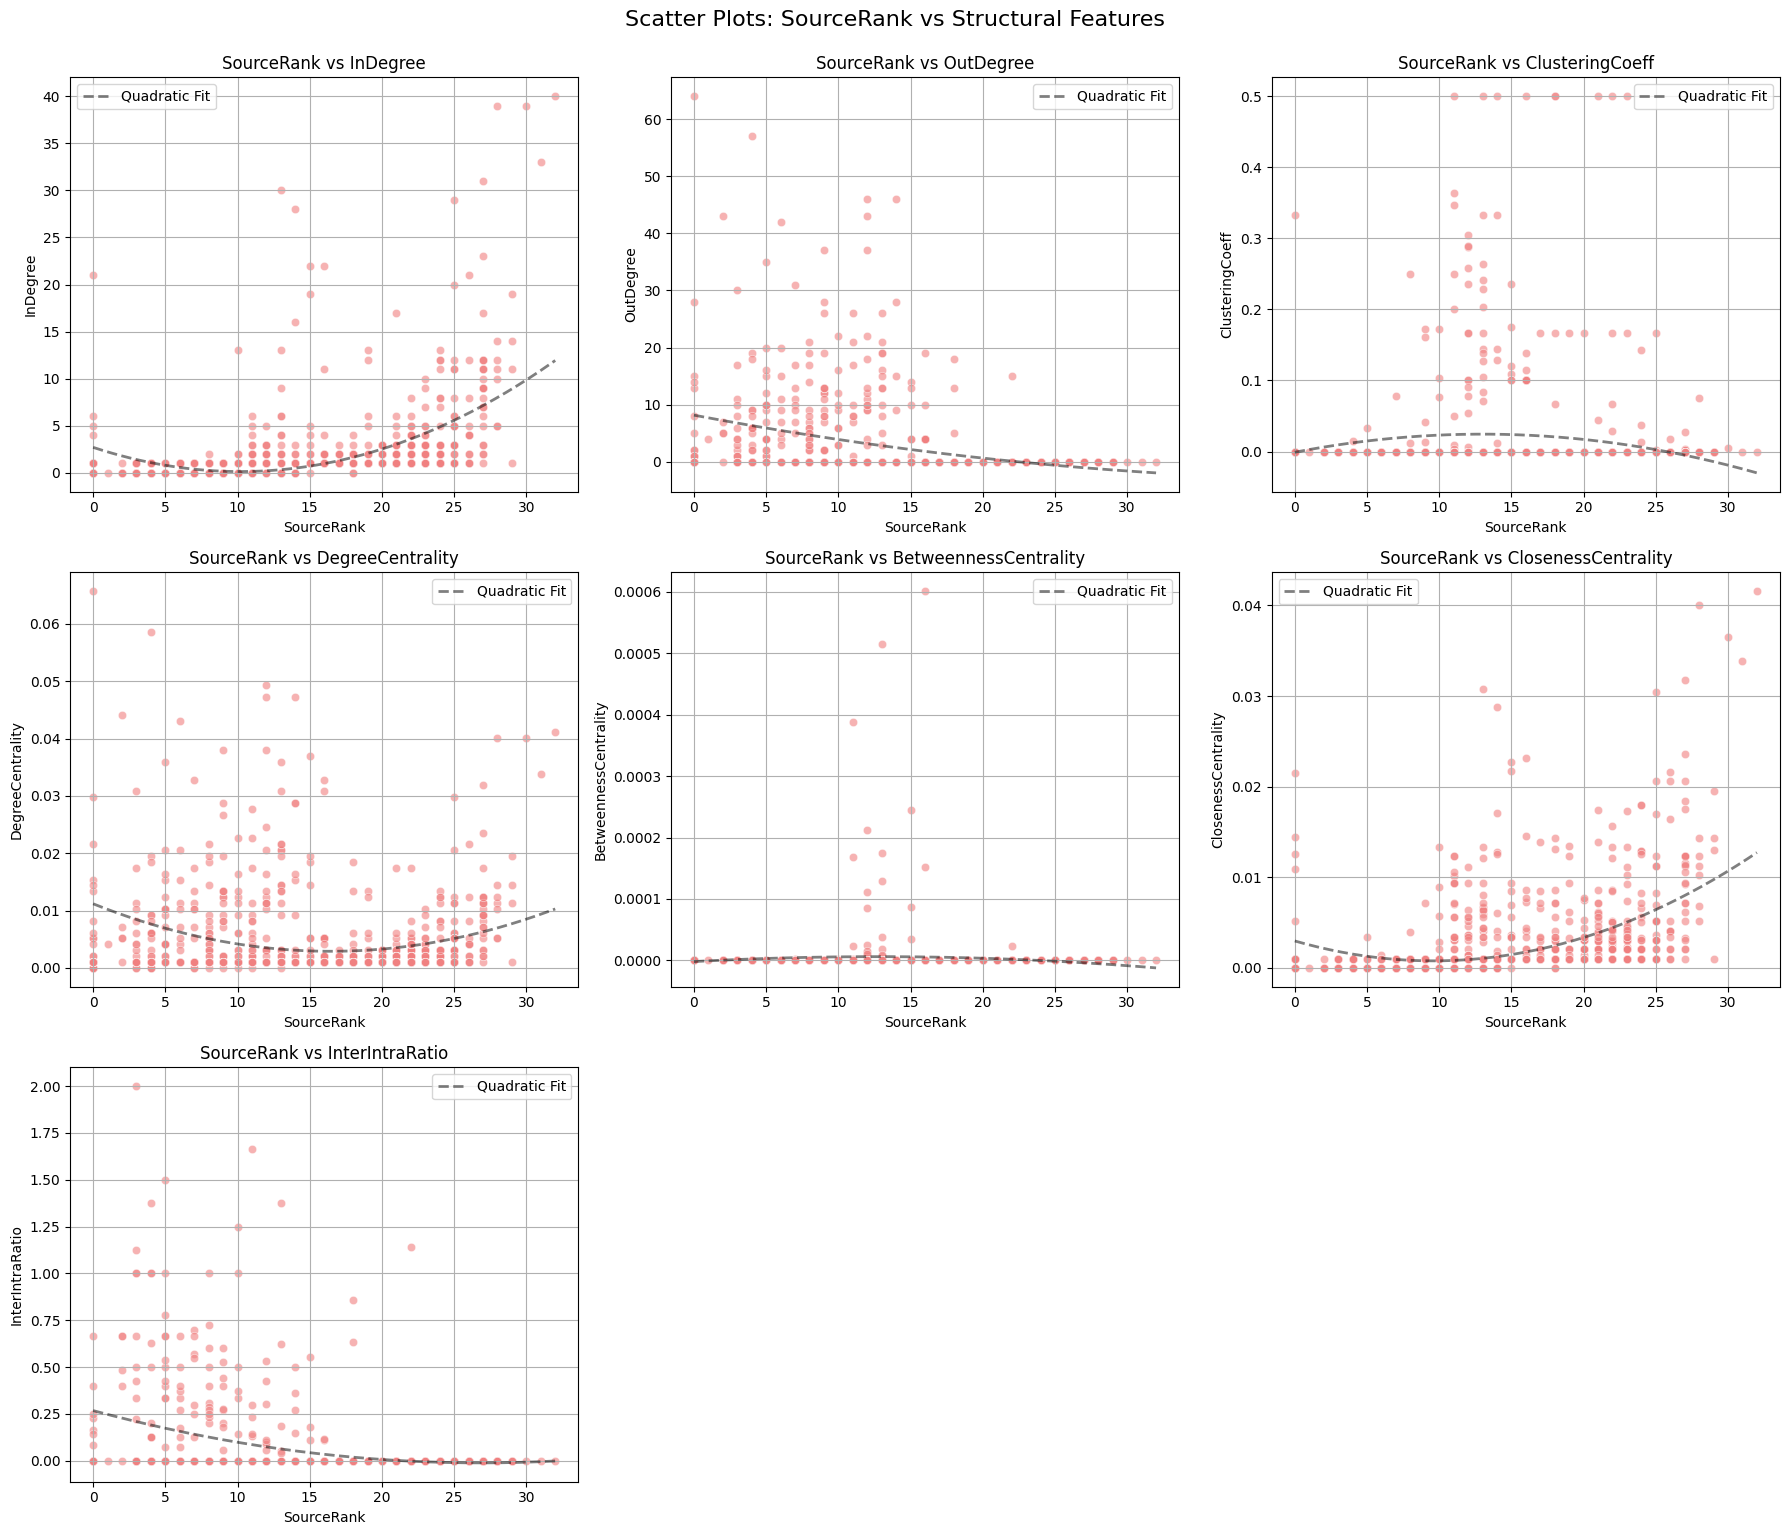

In [23]:
plot_sourcerank_scatter_matrix(df_scatter_recent, color_recent)